<a href="https://colab.research.google.com/github/iskra3138/RL/blob/main/Pybullet_based_SAC_minitaur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Copyright 2020 The TF-Agents Authors.**

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# SAC minitaur with the Actor-Learner API

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/agents/tutorials/7_SAC_minitaur_tutorial">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/7_SAC_minitaur_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/agents/blob/master/docs/tutorials/7_SAC_minitaur_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/agents/docs/tutorials/7_SAC_minitaur_tutorial.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


## Introduction

This example shows how to train a [Soft Actor Critic](https://arxiv.org/abs/1812.05905) agent on the [Minitaur](https://github.com/bulletphysics/bullet3/blob/master/examples/pybullet/gym/pybullet_envs/bullet/minitaur.py) environment.

If you've worked through the [DQN Colab](https://github.com/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb) this should feel very familiar. Notable changes include:

  * Changing the agent from DQN to SAC.
  * Training on Minitaur which is a much more complex environment than CartPole. The Minitaur environment aims to train a quadruped robot to move forward.
  * Using the TF-Agents Actor-Learner API for distributed Reinforcement Learning.

The API supports both distributed data collection using an experience replay buffer and variable container (parameter server) and distributed training across multiple devices. The API is designed to be very simple and modular. We utilize [Reverb](https://deepmind.com/research/open-source/Reverb) for both replay buffer and variable container and [TF DistributionStrategy API](https://www.tensorflow.org/guide/distributed_training) for distributed training on GPUs and TPUs.

If you haven't installed the following dependencies, run:

In [1]:
!pip uninstall tensorflow

Uninstalling tensorflow-2.4.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.4.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.4.0


In [2]:
!sudo apt-get install -y xvfb ffmpeg
!pip install tensorflow==2.3
!pip install gym
!pip install 'imageio==2.4.0'
!pip install matplotlib
!pip install PILLOW
#!pip install tf-agents
!pip install dm-reverb[tensorflow]
!pip install tf-agents
#!pip install tf-agents[reverb]
!pip install pybullet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.8 [784 kB]
Fetched 784 kB in 1s (611 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected pack

     |████████████████████████████████| 3.3MB 8.4MB/s 
  Created wheel for imageio: filename=imageio-2.4.0-cp36-none-any.whl size=3303879 sha256=f68d3651339f4f6899860ff7f6d7e11b783e3ce33d51239fd77b88569a020bca
  Stored in directory: /root/.cache/pip/wheels/31/83/88/a1cba54ac06395d9e4ddcd9cf06911cd0b26cd78af9a61071b
Successfully built imageio
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1
     |████████████████████████████████| 6.2MB 5.5MB/s 
     |████████████████████████████████| 1.1MB 8.1MB/s 
     |████████████████████████████████| 76.6MB 56kB/s 


## Setup

First we will import the different tools that we need.

In [3]:
import base64
import imageio
import IPython
import matplotlib.pyplot as plt
import os
import reverb
import tempfile
import PIL.Image

import tensorflow as tf

from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent
from tf_agents.agents.sac import tanh_normal_projection_network
from tf_agents.environments import suite_pybullet
from tf_agents.experimental.train import actor
from tf_agents.experimental.train import learner
from tf_agents.experimental.train import triggers
from tf_agents.experimental.train.utils import spec_utils
from tf_agents.experimental.train.utils import strategy_utils
from tf_agents.experimental.train.utils import train_utils
from tf_agents.metrics import py_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import greedy_policy
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_py_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils

tempdir = tempfile.gettempdir()

## Hyperparameters

In [4]:
env_name = "MinitaurBulletEnv-v0" # @param {type:"string"}

# Use "num_iterations = 1e6" for better results (2 hrs)
# 1e5 is just so this doesn't take too long (1 hr)
num_iterations = 100000 # @param {type:"integer"}

initial_collect_steps = 10000 # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_capacity = 10000 # @param {type:"integer"}

batch_size = 256 # @param {type:"integer"}

critic_learning_rate = 3e-4 # @param {type:"number"}
actor_learning_rate = 3e-4 # @param {type:"number"}
alpha_learning_rate = 3e-4 # @param {type:"number"}
target_update_tau = 0.005 # @param {type:"number"}
target_update_period = 1 # @param {type:"number"}
gamma = 0.99 # @param {type:"number"}
reward_scale_factor = 1.0 # @param {type:"number"}

actor_fc_layer_params = (256, 256)
critic_joint_fc_layer_params = (256, 256)

log_interval = 5000 # @param {type:"integer"}

num_eval_episodes = 20 # @param {type:"integer"}
eval_interval = 10000 # @param {type:"integer"}

policy_save_interval = 5000 # @param {type:"integer"}

## Environment

Environments in RL represent the task or problem that we are trying to solve. Standard environments can be easily created in TF-Agents using `suites`. We have different `suites` for loading environments from sources such as the OpenAI Gym, Atari, DM Control, etc., given a string environment name.

Now let's load the Minituar environment from the Pybullet suite.

current_dir=/usr/local/lib/python3.6/dist-packages/pybullet_envs/bullet
urdf_root=/usr/local/lib/python3.6/dist-packages/pybullet_data


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


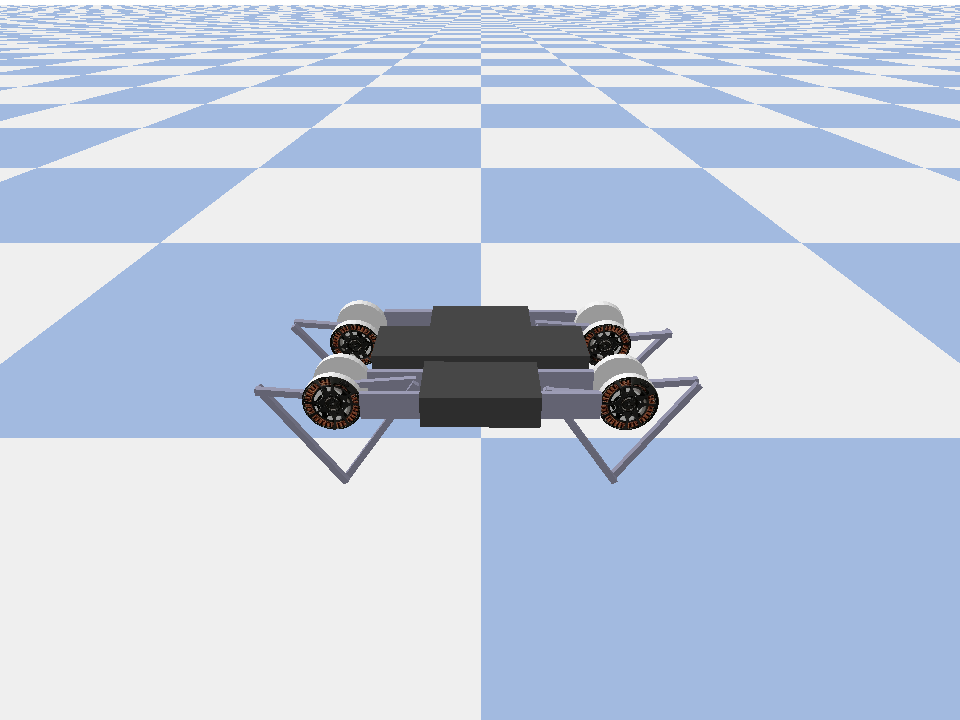

In [5]:
env = suite_pybullet.load(env_name)
env.reset()
PIL.Image.fromarray(env.render())

In this environment the goal is for the agent to train a policy that will control the Minitaur robot and have it move forward as fast as possible. Episodes last 1000 steps and the return will be the sum of rewards throughout the episode.

Let's look at the information the environment provides as an `observation` which the policy will use to generate `actions`.

In [6]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(28,), dtype=dtype('float32'), name='observation', minimum=[  -3.1515927   -3.1515927   -3.1515927   -3.1515927   -3.1515927
   -3.1515927   -3.1515927   -3.1515927 -167.72488   -167.72488
 -167.72488   -167.72488   -167.72488   -167.72488   -167.72488
 -167.72488     -5.71        -5.71        -5.71        -5.71
   -5.71        -5.71        -5.71        -5.71        -1.01
   -1.01        -1.01        -1.01     ], maximum=[  3.1515927   3.1515927   3.1515927   3.1515927   3.1515927   3.1515927
   3.1515927   3.1515927 167.72488   167.72488   167.72488   167.72488
 167.72488   167.72488   167.72488   167.72488     5.71        5.71
   5.71        5.71        5.71        5.71        5.71        5.71
   1.01        1.01        1.01        1.01     ])
Action Spec:
BoundedArraySpec(shape=(8,), dtype=dtype('float32'), name='action', minimum=-1.0, maximum=1.0)


As we can see the observation is fairly complex. We recieve 28 values representing the angles, velocities and torques for all the motors. In return the environment expects 8 values for the actions between `[-1, 1]`. These are the desired motor angles.

Usually we create two environments: one for collecting data during training and one for evaluation. The environments are written in pure python and use numpy arrays, which the Actor Learner API directly consumes.

In [7]:
collect_env = suite_pybullet.load(env_name)
eval_env = suite_pybullet.load(env_name)

urdf_root=/usr/local/lib/python3.6/dist-packages/pybullet_data
urdf_root=/usr/local/lib/python3.6/dist-packages/pybullet_data


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Distribution Strategy
We use the DistributionStrategy API to enable running the train step computation across multiple devices such as multiple GPUs or TPUs using data parallelism. The train step:
* Receives a batch of training data
* Splits it across the devices
* Computes the forward step
* Aggregates and computes the MEAN of the loss
* Computes the backward step and performs a gradient variable update

With TF-Agents Learner API and DistributionStrategy API it is quite easy to switch between running the train step on GPUs (using MirroredStrategy) to TPUs (using TPUStrategy) without changing any of the training logic below.

### Enabling the GPU
If you want to try running on a GPU, you'll first need to enable GPUs for the notebook:

* Navigate to Edit→Notebook Settings
* Select GPU from the Hardware Accelerator drop-down

### Picking a strategy
Use `strategy_utils` to generate a strategy. Under the hood, passing the parameter:
* `use_gpu = False` returns `tf.distribute.get_strategy()`, which uses CPU
* `use_gpu = True` returns `tf.distribute.MirroredStrategy()`, which uses all GPUs that are visible to TensorFlow on one machine

In [8]:
use_gpu = True #@param {type:"boolean"}

strategy = strategy_utils.get_strategy(tpu=False, use_gpu=use_gpu)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


All variables and Agents need to be created under `strategy.scope()`, as you'll see below.

## Agent

To create an SAC Agent, we first need to create the networks that it will train. SAC is an actor-critic agent, so we will need two networks.

The critic will give us value estimates for `Q(s,a)`. That is, it will recieve as input an observation and an action, and it will give us an estimate of how good that action was for the given state.


In [9]:
observation_spec, action_spec, time_step_spec = (
      spec_utils.get_tensor_specs(collect_env))

with strategy.scope():
  critic_net = critic_network.CriticNetwork(
        (observation_spec, action_spec),
        observation_fc_layer_params=None,
        action_fc_layer_params=None,
        joint_fc_layer_params=critic_joint_fc_layer_params,
        kernel_initializer='glorot_uniform',
        last_kernel_initializer='glorot_uniform')

We will use this critic to train an `actor` network which will allow us to generate actions given an observation.

The `ActorNetwork` will predict parameters for a tanh-squashed [MultivariateNormalDiag](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MultivariateNormalDiag) distribution. This distribution will then be sampled, conditioned on the current observation, whenever we need to generate actions.

In [10]:
with strategy.scope():
  actor_net = actor_distribution_network.ActorDistributionNetwork(
      observation_spec,
      action_spec,
      fc_layer_params=actor_fc_layer_params,
      continuous_projection_net=(
          tanh_normal_projection_network.TanhNormalProjectionNetwork))

With these networks at hand we can now instantiate the agent.


In [11]:
with strategy.scope():
  train_step = train_utils.create_train_step()

  tf_agent = sac_agent.SacAgent(
        time_step_spec,
        action_spec,
        actor_network=actor_net,
        critic_network=critic_net,
        actor_optimizer=tf.compat.v1.train.AdamOptimizer(
            learning_rate=actor_learning_rate),
        critic_optimizer=tf.compat.v1.train.AdamOptimizer(
            learning_rate=critic_learning_rate),
        alpha_optimizer=tf.compat.v1.train.AdamOptimizer(
            learning_rate=alpha_learning_rate),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        td_errors_loss_fn=tf.math.squared_difference,
        gamma=gamma,
        reward_scale_factor=reward_scale_factor,
        train_step_counter=train_step)

  tf_agent.initialize()

## Replay Buffer

In order to keep track of the data collected from the environment, we will use [Reverb](https://deepmind.com/research/open-source/Reverb), an efficient, extensible, and easy-to-use replay system by Deepmind. It stores experience data collected by the Actors and consumed by the Learner during training.

In this tutorial, this is less important than `max_size` -- but in a distributed setting with async collection and training, you will probably want to experiment with `rate_limiters.SampleToInsertRatio`, using a samples_per_insert somewhere between 2 and 1000. For example:
```
rate_limiter=reverb.rate_limiters.SampleToInsertRatio(samples_per_insert=3.0, min_size_to_sample=3, error_buffer=3.0))
```




In [12]:
table_name = 'uniform_table'
table = reverb.Table(
    table_name,
    max_size=replay_buffer_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1))

reverb_server = reverb.Server([table])

The replay buffer is constructed using specs describing the tensors that are to be stored, which can be obtained from the agent using `tf_agent.collect_data_spec`.

Since the SAC Agent needs both the current and next observation to compute the loss, we set `sequence_length=2`.

In [13]:
reverb_replay = reverb_replay_buffer.ReverbReplayBuffer(
    tf_agent.collect_data_spec,
    sequence_length=2,
    table_name=table_name,
    local_server=reverb_server)

Now we generate a TensorFlow dataset from the Reverb replay buffer. We will pass this to the Learner to sample experiences for training.

In [14]:
dataset = reverb_replay.as_dataset(
      sample_batch_size=batch_size, num_steps=2).prefetch(50)
experience_dataset_fn = lambda: dataset

## Policies

In TF-Agents, policies represent the standard notion of policies in RL: given a `time_step` produce an action or a distribution over actions. The main method is `policy_step = policy.step(time_step)` where `policy_step` is a named tuple `PolicyStep(action, state, info)`.  The `policy_step.action` is the `action` to be applied to the environment, `state` represents the state for stateful (RNN) policies and `info` may contain auxiliary information such as log probabilities of the actions.

Agents contain two policies:

-   `agent.policy` — The main policy that is used for evaluation and deployment.
-   `agent.collect_policy` — A second policy that is used for data collection.

In [15]:
tf_eval_policy = tf_agent.policy
eval_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_eval_policy, use_tf_function=True)

In [16]:
tf_collect_policy = tf_agent.collect_policy
collect_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_collect_policy, use_tf_function=True)

Policies can be created independently of agents. For example, use `tf_agents.policies.random_py_policy` to create a policy which will randomly select an action for each time_step.

In [17]:
random_policy = random_py_policy.RandomPyPolicy(
  collect_env.time_step_spec(), collect_env.action_spec())

## Actors
The actor manages interactions between a policy and an environment.
  * The Actor components contain an instance of the environment (as `py_environment`) and a copy of the policy variables.
  * Each Actor worker runs a sequence of data collection steps given the local values of the policy variables.
  * Variable updates are done explicitly using the variable container client instance in the training script before calling `actor.run()`.
  * The observed experience is written into the replay buffer in each data collection step.

As the Actors run data collection steps, they pass trajectories of (state, action, reward) to the observer, which caches and writes them to the Reverb replay system. 

We're storing trajectories for frames [(t0,t1) (t1,t2) (t2,t3), ...] because `stride_length=1`.

In [18]:
rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  reverb_replay.py_client,
  table_name,
  sequence_length=2,
  stride_length=1)

We create an Actor with the random policy and collect experiences to seed the replay buffer with.

In [19]:
initial_collect_actor = actor.Actor(
  collect_env,
  random_policy,
  train_step,
  steps_per_run=initial_collect_steps,
  observers=[rb_observer])
initial_collect_actor.run()

Instantiate an Actor with the collect policy to gather more experiences during training.

In [20]:
env_step_metric = py_metrics.EnvironmentSteps()
collect_actor = actor.Actor(
  collect_env,
  collect_policy,
  train_step,
  steps_per_run=1,
  metrics=actor.collect_metrics(10),
  summary_dir=os.path.join(tempdir, learner.TRAIN_DIR),
  observers=[rb_observer, env_step_metric])

Create an Actor which will be used to evaluate the policy during training. We pass in `actor.eval_metrics(num_eval_episodes)` to log metrics later.

In [21]:
eval_actor = actor.Actor(
  eval_env,
  eval_policy,
  train_step,
  episodes_per_run=num_eval_episodes,
  metrics=actor.eval_metrics(num_eval_episodes),
  summary_dir=os.path.join(tempdir, 'eval'),
)

## Learners
The Learner component contains the agent and performs gradient step updates to the policy variables using experience data from the replay buffer. After one or more training steps, the Learner can push a new set of variable values to the variable container.

In [22]:
saved_model_dir = os.path.join(tempdir, learner.POLICY_SAVED_MODEL_DIR)

# Triggers to save the agent's policy checkpoints.
learning_triggers = [
    triggers.PolicySavedModelTrigger(
        saved_model_dir,
        tf_agent,
        train_step,
        interval=policy_save_interval),
    triggers.StepPerSecondLogTrigger(train_step, interval=1000),
]

agent_learner = learner.Learner(
  tempdir,
  train_step,
  tf_agent,
  experience_dataset_fn,
  triggers=learning_triggers)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/policies/collect_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/collect_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/greedy_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/greedy_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/policy/assets


## Metrics and Evaluation

We instantiated the eval Actor with `actor.eval_metrics` above, which creates most commonly used metrics during policy evaluation:
* Average return. The return is the sum of rewards obtained while running a policy in an environment for an episode, and we usually average this over a few episodes.
* Average episode length.

We run the Actor to generate these metrics.

In [23]:
def get_eval_metrics():
  eval_actor.run()
  results = {}
  for metric in eval_actor.metrics:
    results[metric.name] = metric.result()
  return results

metrics = get_eval_metrics()

In [24]:
def log_eval_metrics(step, metrics):
  eval_results = (', ').join(
      '{} = {:.6f}'.format(name, result) for name, result in metrics.items())
  print('step = {0}: {1}'.format(step, eval_results))

log_eval_metrics(0, metrics)

step = 0: AverageReturn = -0.191911, AverageEpisodeLength = 65.750000


Check out the [metrics module](https://github.com/tensorflow/agents/blob/master/tf_agents/metrics/tf_metrics.py) for other standard implementations of different metrics.

## Training the agent

The training loop involves both collecting data from the environment and optimizing the agent's networks. Along the way, we will occasionally evaluate the agent's policy to see how we are doing.

In [25]:
#@test {"skip": true}
try:
  %%time
except:
  pass

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = get_eval_metrics()["AverageReturn"]
returns = [avg_return]

for _ in range(num_iterations):
  # Training.
  collect_actor.run()
  loss_info = agent_learner.run(iterations=1)

  # Evaluating.
  step = agent_learner.train_step_numpy

  if eval_interval and step % eval_interval == 0:
    metrics = get_eval_metrics()
    log_eval_metrics(step, metrics)
    returns.append(metrics["AverageReturn"])

  if log_interval and step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, loss_info.loss.numpy()))

rb_observer.close()
reverb_server.stop()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
step = 5000: loss = -52.282386779785156
step = 10000: AverageReturn = -0.091339, AverageEpisodeLength = 135.149994
step = 10000: loss = -60.35587692260742
step = 15000: loss = -29.584978103637695
step = 20000: AverageReturn = -0.984484, AverageEpisodeLength = 416.950012
step = 20000: loss = -23.452877044677734
step = 25000: loss = -11.997552871704102
step = 30000: AverageReturn = -0.416938, AverageEpisodeLength = 250.050003
step = 30000: loss = -6.283180236816406
step = 35000: loss = -4.234858989715576
step = 40000: AverageReturn = -0.902823, AverageEpisodeLength = 425.250000
step = 40000: loss = -2.9952750205993652
step = 45000: loss = -2.1303040981292725
step = 50000: AverageReturn = -0.454159, AverageEpisodeLength = 292.399994
step = 50000: loss = -0.062408268451690674
step = 55000: loss = -1.5347120761871338
step = 60000: AverageReturn = -1.191886, AverageEpisodeLength = 414.500000
step = 60000: loss = 1.42153024673461

## Visualization


### Plots

We can plot average return vs global steps to see the performance of our agent. In `Minitaur`, the reward function is based on how far the minitaur walks in 1000 steps and penalizes the energy expenditure.

(-1.2521479085087777, 0.07360997349023819)

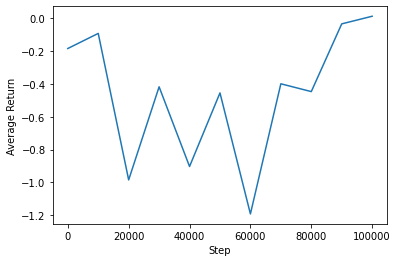

In [26]:
#@test {"skip": true}

steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim()

### Videos

It is helpful to visualize the performance of an agent by rendering the environment at each step. Before we do that, let us first create a function to embed videos in this colab.

In [27]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

The following code visualizes the agent's policy for a few episodes:

In [29]:
num_episodes = 30
video_filename = 'sac_minitaur.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_env.render())
    while not time_step.is_last():
      action_step = eval_actor.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_env.render())

embed_mp4(video_filename)